In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import metpy
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
from scipy import stats
import matplotlib.pyplot as plt
import tropycal
from tropycal import tracks
from shapely.geometry import Polygon, Point
import xarray as xr
import os

In [2]:
def superimpose_rain_onto_bigger_grid(storm,ntime,grid_x,grid_y,combo=False,truth=False):
    grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))

    if (combo == True) or (truth == True):
        grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

    for t in range(ntime):
        s_lons = storm.storm_lons[t,:,:]
        s_lats = storm.storm_lats[t,:,:]
        
        if truth==True:
            storm_rain_truth = storm.precipitation[t,:,:,0]

        Mlon = s_lons[-1,-1].values
        mlon = s_lons[0,0].values
        Mlat = s_lats[-1,-1].values
        mlat = s_lats[0,0].values
        # print(Mlat,mlat,Mlon,mlon)
        if Mlon < mlon:
            print(Mlat,mlat,Mlon,mlon)
            print('error')
            continue
        # print(grid_x,grid_y)
        Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
        Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

        # Create a selection
        sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

        if truth == False:
            for i in range(20):
                storm_rain = storm.precipitation[t,:,:,i].values
                grid_rain[t,sel[1],sel[0],i] = storm_rain
            
        else:
            grid_rain[t,sel[1],sel[0]] = storm_rain_truth
    
    return grid_rain
        

In [3]:
def find_storm_extent(lat,lon,storm):

    lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats.values))).argmin()
    lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats.values))).argmin()
    lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons.values))).argmin()
    lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons.values))).argmin()

    lats = lat[lat_lower_bound:lat_upper_bound+2]
    lons = lon[lon_lower_bound:lon_upper_bound+2]
    grid_x, grid_y = np.meshgrid(lons,lats)
    return grid_x,grid_y

In [4]:
rain = np.load('/user/home/al18709/work/event_sets/MSWEP/accumulated_global.npy')

In [5]:
files = os.listdir('/user/home/al18709/work/event_sets/MSWEP/')
sids = []
for file in files:
    if ('.nc' in file):
        sid = file[6:-3]
        sids.append(sid)

In [6]:
print(len(sids))

1254


In [7]:
ds = xr.load_dataset('/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc')
lat = ds.lat.values
lon = ds.lon.values
lons, lats = np.meshgrid(lon,lat)

In [8]:
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count.population.values * 144
population = population_count.population.values * 144
pop = population_count * 144
pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -3.403e+38 -3.403e+38 ... -3.403e+38
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


/tmp/ipykernel_93810/2452979358.py:4: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144
/tmp/ipykernel_93810/2452979358.py:5: RuntimeWarning: overflow encountered in multiply
  population = population_count.population.values * 144


In [19]:
# global_rain = np.zeros((pop.population.shape[0],pop.population.shape[1]))
# for sid in sids:
#     storm = xr.open_dataset('/user/home/al18709/work/event_sets/MSWEP/' + f'mswep_{sid}.nc')
#     rain = storm.precipitation[0,:,:,0].values
#     ntime,_,_,_ = storm.precipitation.shape
#     grid_x,grid_y = find_storm_extent(lat,lon,storm)
#     grid_rain = superimpose_rain_onto_bigger_grid(storm,ntime,grid_x,grid_y,combo=False,truth=True)
#     accumulated_rain = np.sum(grid_rain[:,:,:],axis=0)

#     # superimpose rain onto global grid
#     storm_lons = grid_x
#     storm_lats = grid_y

#     Mlon = storm_lons[-1,-1]
#     mlon = storm_lons[0,0]
#     Mlat = storm_lats[-1,-1]
#     mlat = storm_lats[0,0]
#     grid_X,grid_Y = np.meshgrid(lon,lat)
#     Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
#     Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

#     # Create a selection
#     sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
#     global_rain[sel[1],sel[0]] = global_rain[sel[1],sel[0]] + accumulated_rain

NameError: name 'grid_X' is not defined

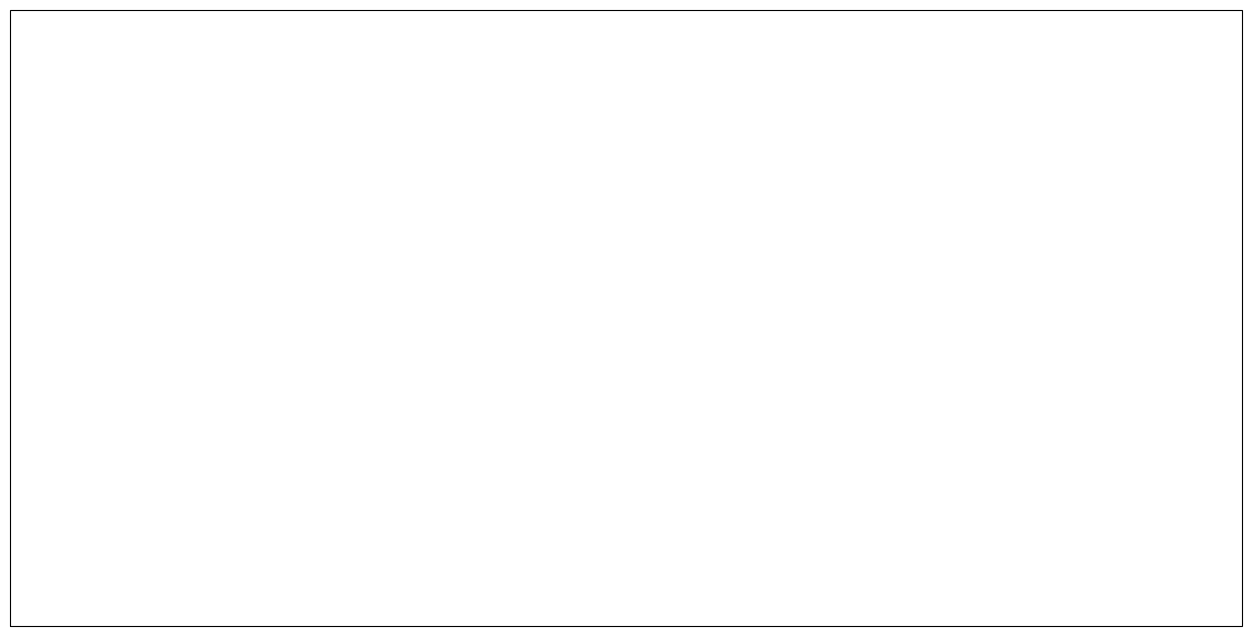

In [9]:
levels = [100, 150, 200, 250, 300, 400, 500,750, 1000,1400,1800,2000,2500,3000,4000,5000,10000]
fig, ax = plt.subplots(1,1,figsize=(16,8),subplot_kw={'projection': ccrs.PlateCarree()})
vmin=0
vmax=300

ax.contourf(grid_X,grid_Y,rain,cmap=precip_cmap,levels =levels, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
# plt.gca().invert_yaxis()

In [10]:
precip_cmap,precip_norm = make_cmap()

In [11]:
def make_cmap(high_vals=False,low_vals=False):
	precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
	if high_vals==True:
		# precip_clevs = [0, 20, 25, 30, 40, 50, 70, 100, 125, 150, 175,200, 225, 250, 300, 350, 400, 500]
		precip_clevs = [0, 20, 40, 60, 80, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500]
	if low_vals == True:
		precip_clevs = [0, 2, 4, 6, 8, 10, 12, 14, 16, 19, 20, 22, 24, 26, 28, 30]
	precip_cmap = matplotlib.colors.ListedColormap(metpy.plots.ctables.colortables["precipitation"][:len(precip_clevs)-1], 'precipitation')
	precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

	tc_colours = [(255/255,255/255,255/255), # no rain
				(169/255, 209/255, 222/255), # drizzle 0-1
				(137/255, 190/255, 214/255), # drizzle 1-2
				(105/255, 160/255, 194/255), # drizzle 2-3
				(93/255, 168/255, 98/255), # drizzle 3-5
				(128/255, 189/255, 100/255), # very light rain 5-7
				(165/255, 196/255, 134/255), # light rain 7-10
				(233/255, 245/255, 105/255), # rain 10-15
				(245/255, 191/255, 105/255), # heavy rain 15-20
				(245/255, 112/255, 105/255), # heavier rain 20-25
				(245/255, 105/255, 149/255), # real heavy rain 25-30
				(240/255, 93/255, 154/255), # intense rain 30-40
				(194/255, 89/255, 188/255), # super intense rain 40-50
				(66/255, 57/255, 230/255), # insane amount of rain 50-70
				(24/255, 17/255, 153/255), # you do not want to be caught in this rain 70-100
				(9/255, 5/255, 87/255), # I can't belive the scale goes up this high 100-150
	]
	if high_vals == False:
		N = 16
	else:
		N=16
	precip_cmap = LinearSegmentedColormap.from_list('tc_colours',tc_colours,N=N) #increasing N makes it smoother
	precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N,extend='max')
	return precip_cmap,precip_norm

In [12]:
def make_cmap2(high_vals=False, low_vals=False):
    tc_colours = [
        (169/255, 209/255, 222/255),  # drizzle 0-1
        (137/255, 190/255, 214/255),  # drizzle 1-2
        (105/255, 160/255, 194/255),  # drizzle 2-3
        (93/255, 168/255, 98/255),    # drizzle 3-5
        (128/255, 189/255, 100/255),  # very light rain 5-7
        (165/255, 196/255, 134/255),  # light rain 7-10
        (233/255, 245/255, 105/255),  # rain 10-15
        (245/255, 191/255, 105/255),  # heavy rain 15-20
        (245/255, 112/255, 105/255),  # heavier rain 20-25
        (245/255, 105/255, 149/255),  # real heavy rain 25-30
        (240/255, 93/255, 154/255),   # intense rain 30-40
        (194/255, 89/255, 188/255),   # super intense rain 40-50
        (66/255, 57/255, 230/255),    # insane amount of rain 50-70
        (24/255, 17/255, 153/255),    # you do not want to be caught in this rain 70-100
        (9/255, 5/255, 87/255)        # I can't believe the scale goes up this high 100-150
    ]

    if high_vals == False:
        N = 16
    else:
        N = 16

    # Remove the first color (white)
    tc_colours = tc_colours[1:]

    # Start at the first blue color
    precip_cmap = LinearSegmentedColormap.from_list('tc_colours', tc_colours, N=N)

    # Create a list of colors between each pair of adjacent colors
    new_tc_colours = []
    for i in range(len(tc_colours) - 1):
        new_color = np.linspace(tc_colours[i], tc_colours[i + 1], num=10)
        new_tc_colours.extend(new_color[:-1])  # Avoid duplicates
    new_tc_colours.append(tc_colours[-1])  # Add the last color

    # Create a new colormap with more gradual transitions
    precip_cmap = LinearSegmentedColormap.from_list('new_tc_colours', new_tc_colours, N=N)

    precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
    precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

    return precip_cmap, precip_norm

In [13]:
precip_cmap, precip_norm = make_cmap2()

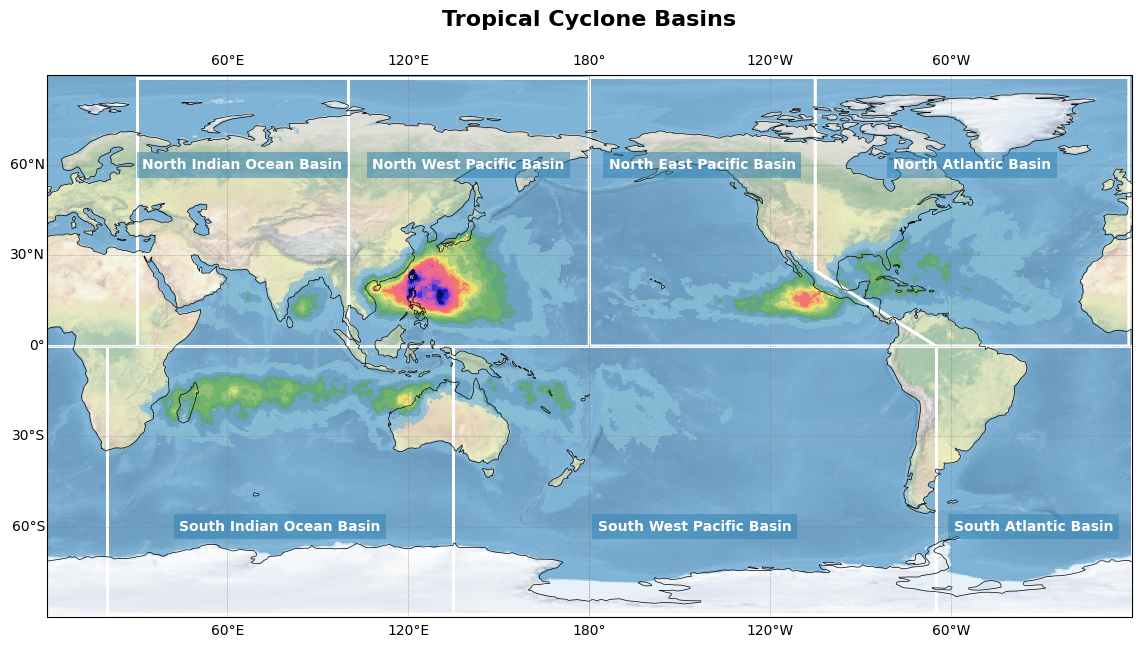

In [15]:
# Create a new figure
plt.figure(figsize=(14, 8))
levels = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 7000, 10000]
levels = range(0,10000,200)[1:]

# Define the projection (PlateCarree for a simple cylindrical projection)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  # Centered on the Pacific Ocean
lons2 = (lons + 180)


# look at land only
ax.contourf(lons2,lats,rain,cmap=precip_cmap,levels =levels,alpha=0.8)

# Add coastlines with thinner lines
ax.stock_img()
ax.coastlines(resolution='110m', linewidth=0.5)

# Add grid lines with dotted linestyle
gl = ax.gridlines(draw_labels=True, linestyle=':',color='Gray',linewidth=0.5)

# Label x and y axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set title
ax.set_title('Tropical Cyclone Basins', loc='center',pad=20,weight='bold',fontsize=16)

# Add boxes and text annotations for the tropical cyclone basins
basins = {
    # 'North Atlantic Basin': (85, 179, 0, 90),
    'North Atlantic Basin': [ (75, 25), (75, 89),(85, 89), (179, 89), (179, 0), (115, 0)],
    'North Indian Ocean Basin': (-150, -80, 0, 89),
    # 'North East Pacific Basin': (0, 85, 0,90),
    'North West Pacific Basin': (-80, 0, 0, 89),
    'North East Pacific Basin': [(0,0),(0,89),(75,89),(75,25),(115,0)],
    'South Indian Ocean Basin': (-160, -45, -89, 0),
    # # 'Australian Region': (100, 180, -50, -10),
    'South West Pacific Basin': (-45, 115, -89, 0),
    'South Atlantic Basin': (115, 180, -89, 0),
    '': (-180, -160, -90, 0),
}


# for basin, coords in basins.items():
#     if isinstance(coords, list):
#             basin_patch = plt.Polygon(coords, edgecolor='red', facecolor='none', linewidth=2)
#     else:
#         basin_patch = plt.Rectangle((coords[0], coords[2]), coords[1] - coords[0], coords[3] - coords[2],
#                                         edgecolor='red', facecolor='none', linewidth=2)
#     ax.add_patch(basin_patch)
    
for basin, bbox in basins.items():
    if isinstance(bbox, list):
        basin_patch = plt.Polygon(bbox, edgecolor='white', facecolor='none', linewidth=2)
    else:
        # basin_patch = plt.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0], bbox[3] - bbox[2],
        #                         edgecolor='white', facecolor='none', linewidth=2)
        basin_patch = plt.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0], bbox[3] - bbox[2],
                                        edgecolor='white', facecolor='none', linewidth=2)
        ax.add_patch(basin_patch)
    ax.add_patch(basin_patch)

    if isinstance(bbox, list):
        text_x = (bbox[0][0] + bbox[3][0]) / 2  # Calculate x-coordinate for text
        text_y = 60  # Calculate y-coordinate for text
    else:
        text_x = (bbox[0] + bbox[1]) / 2  # Calculate x-coordinate for text
        if bbox[2] < 0:
            text_y = -60 # (bbox[2] + bbox[3]) / 2  # Calculate y-coordinate for text
        else:
            text_y = 60
    ax.text(text_x, text_y, basin, color='white',weight='bold', fontsize=10, ha='center', va='center',bbox=dict(facecolor='#2b81b3', alpha=0.5, edgecolor='none'))



# Show the plot
plt.savefig('TC_basins_rain.png',bbox_inches='tight',dpi=300)

# Tropical Cyclones and Climate Change Assessment Part II: Projected Response to Anthropogenic Warming Supplementary



In [16]:
from global_land_mask import globe

In [21]:
z = globe.is_land(lats,lons)
print(z.shape)
print(rain.shape)

(1800, 3600)
(1800, 3600)


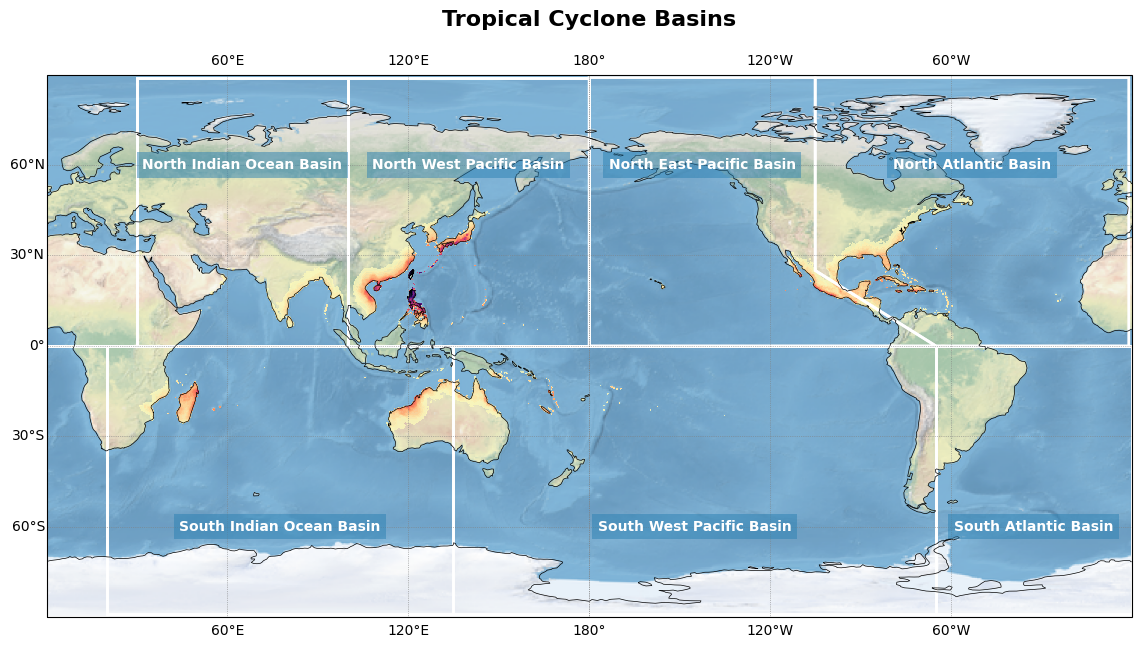

In [33]:
# mask for land and high rainfall
land_rain = rain * z
# z2 = land_rain >= 100
# extreme_rain = land_rain * z2

# Create a new figure
plt.figure(figsize=(14, 8))
levels = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 7000, 10000]
levels = range(0,10000,200)[1:]

# Define the projection (PlateCarree for a simple cylindrical projection)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  # Centered on the Pacific Ocean
lons2 = (lons + 180)


# look at land only
# ax.contourf(lons2,lats,rain,cmap=precip_cmap,levels =levels,alpha=0.8)
# ax.contourf(lons2,lats,land_rain,cmap=precip_cmap,levels =levels,alpha=0.8)
# ax.contourf(lons2,lats,land_rain,cmap='viridis_r',levels =levels,alpha=0.8)
# ax.contourf(lons2,lats,land_rain,cmap='plasma_r',levels =levels,alpha=0.8)
ax.contourf(lons2,lats,land_rain,cmap='magma_r',levels =levels,alpha=0.8)
# ax.contourf(lons2,lats,extreme_rain,cmap=precip_cmap,levels =levels,alpha=0.8)

# Add coastlines with thinner lines
ax.stock_img()
# ax.coastlines(resolution='110m', linewidth=0.5)
ax.coastlines(resolution='110m', linewidth=0.5)

# Add grid lines with dotted linestyle
gl = ax.gridlines(draw_labels=True, linestyle=':',color='Gray',linewidth=0.5)

# Label x and y axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set title
ax.set_title('Tropical Cyclone Basins', loc='center',pad=20,weight='bold',fontsize=16)

# Add boxes and text annotations for the tropical cyclone basins
basins = {
    'North Atlantic Basin': [ (75, 25), (75, 89),(85, 89), (179, 89), (179, 0), (115, 0)],
    'North Indian Ocean Basin': (-150, -80, 0, 89),
    'North West Pacific Basin': (-80, 0, 0, 89),
    'North East Pacific Basin': [(0,0),(0,89),(75,89),(75,25),(115,0)],
    'South Indian Ocean Basin': (-160, -45, -89, 0),
    'South West Pacific Basin': (-45, 115, -89, 0),
    'South Atlantic Basin': (115, 180, -89, 0),
    '': (-180, -160, -90, 0),
}
    
for basin, bbox in basins.items():
    if isinstance(bbox, list):
        basin_patch = plt.Polygon(bbox, edgecolor='white', facecolor='none', linewidth=2)
    else:
        # basin_patch = plt.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0], bbox[3] - bbox[2],
        #                         edgecolor='white', facecolor='none', linewidth=2)
        basin_patch = plt.Rectangle((bbox[0], bbox[2]), bbox[1] - bbox[0], bbox[3] - bbox[2],
                                        edgecolor='white', facecolor='none', linewidth=2)
        ax.add_patch(basin_patch)
    ax.add_patch(basin_patch)

    if isinstance(bbox, list):
        text_x = (bbox[0][0] + bbox[3][0]) / 2  # Calculate x-coordinate for text
        text_y = 60  # Calculate y-coordinate for text
    else:
        text_x = (bbox[0] + bbox[1]) / 2  # Calculate x-coordinate for text
        if bbox[2] < 0:
            text_y = -60 # (bbox[2] + bbox[3]) / 2  # Calculate y-coordinate for text
        else:
            text_y = 60
    ax.text(text_x, text_y, basin, color='white',weight='bold', fontsize=10, ha='center', va='center',bbox=dict(facecolor='#2b81b3', alpha=0.5, edgecolor='none'))



# Show the plot
# plt.savefig('TC_basins.png',bbox_inches='tight',dpi=300)

# Tropical Cyclones and Climate Change Assessment Part II: Projected Response to Anthropogenic Warming Supplementary

